In [1]:
import os
import json
import numpy as np
import random
import tensorflow as tf
import csv
import re

import pandas as pd
import csv
import matplotlib.pyplot as plt
import math
import numpy as np
from collections import Counter


In [2]:
seed = 123
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

In [3]:
# tokenSelector c/c++

def replace_strings_and_numericals(source_code, strings, numericals):
    
    if strings == 1:
        # Replace strings with "STR$ID"
        modified_code = re.sub(r'(\"[^\"]*\"|\'.*?\')', '"STR$ID"', source_code)
    else:
        modified_code = source_code
    
    if numericals == 1:
        # Replace numerical values with "NUM%ID"
        modified_code = re.sub(r'\b\d+\b', 'NUM%ID', modified_code)
    
    return modified_code

def remove_import_statements(source_code):
    # Remove #include statements
    modified_code = re.sub(r'^\s*#include\s+.+?(\n|$)', '', source_code, flags=re.MULTILINE)
    
    return modified_code

def remove_comments(source_code):
    # Remove single-line comments
    modified_code = re.sub(r'\/\/.*', '', source_code)
    
    # Remove multi-line comments
    modified_code = re.sub(r'\/\*[\s\S]*?\*\/', '', modified_code)
    
    return modified_code

def convert_to_lowercase(source_code):
    # Convert all letters to lowercase
    return source_code.lower()

def remove_blank_lines(source_code):
    # Remove blank lines
    return re.sub(r'^\s*\n', '', source_code, flags=re.MULTILINE)

def dataTokenization(dataset, comments, strings, numericals, headers):    
    for i in range(len(dataset)):
        
        source_code = dataset[i]
        
        source_code = replace_strings_and_numericals(source_code, strings, numericals)
        
        if headers == 1:
            source_code = remove_import_statements(source_code)
        
        if comments == 1:
            source_code = remove_comments(source_code)
        
        source_code = convert_to_lowercase(source_code)
        
        source_code = remove_blank_lines(source_code)
        
        dataset[i] = source_code
        
    return dataset

In [4]:
# dataAnalyzer

def uniqueWords(word_list):
    # Concatenate all strings in the list into one big string
    big_string = ' '.join(word_list)
    
    # Split the big string into individual words
    all_words = big_string.split()
    
    # Find unique words
    unique_words = list(set(all_words))
    
    # Count the occurrences of each word
    word_counts = Counter(all_words)
    
    # Create DataFrame from word_counts
    word_counts_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Count']).sort_values(by='Count', ascending=False)
    
    return all_words, unique_words, word_counts_df

def labelFrequencies(data):
    values = []
    for i in range(len(data)):
        values.append(data[i])
    serVal = pd.DataFrame(values)
    return serVal

def getLengths(string_list):
    # Initialize an empty list to store lengths
    lengths = []

    # Iterate over each string in the list
    for string in string_list:
        # Split the string into tokens (words)
        tokens = string.split()
        # Calculate the length (number of tokens) of the string
        length = len(tokens)
        # Append the length to the lengths list
        lengths.append(length)

    return lengths

def optLength(data):    
    #find the words, the unique words and their frequencies       
    allWords, uniques, tokenFreq = uniqueWords(data["func"])

    #     #write uniques to file
    #     textfile = open("uniques.txt", "w", encoding='utf-8')
    #     for element in uniques:
    #         print(element)
    #         textfile.write(element + "\n")
    #     textfile.close()

    #check balance
    labels = labelFrequencies(data["target"])
    labelFreq = labels[0].value_counts()
    print("labels balance:\n",labelFreq)

    # find the length of each class file
    lens = getLengths(data["func"])

    avgLen = np.mean(lens)
    print("avg of lengths = ", avgLen)
    print("max of lengths = ", max(lens))
    print("min of lengths = ", min(lens))

    len_sorted = sorted(lens)

    med = np.median(len_sorted)
    print("median= ", med)

    plt.plot(len_sorted)
    plt.show()

    stdev = np.std(len_sorted)
    print("standard deviation = ", stdev)

    split_point = int(med + 2*stdev)
    print("median + 2*st.d= ", split_point)
    max_len_std = len_sorted[split_point-1]
    print("max length selected, based on median + 2*st.d: ", max_len_std)

    #boxplot = len_sorted.boxplot(column=[0])
    plt.boxplot(len_sorted)
    plt.show()

    # finding the 1st and 3rd quartiles
    q1 = np.quantile(len_sorted, 0.25)
    q3 = np.quantile(len_sorted, 0.75)
    # finding the iqr region
    iqr = q3-q1
    # finding upper and lower whiskers
    upper_bound = q3+(1.5*iqr)
    lower_bound = q1-(1.5*iqr)
    print(iqr, upper_bound, lower_bound)

    len_sorted = np.array(len_sorted)
    outliers = len_sorted[(len_sorted <= lower_bound) | (len_sorted >= upper_bound)]
    split_point = len(len_sorted) - len(outliers)
    print("IQR-based splitting point: ", split_point)
    max_len_iqr = len_sorted[split_point-1]
    print("max length selected, based on IQR: ", max_len_iqr)

    #reshape dataset
    max_len = max_len_iqr
    data['length'] = lens

    filtered_data = data[data['length'] < max_len]
    
    return filtered_data



labels balance:
 1    4981
0    4788
Name: 0, dtype: int64
avg of lengths =  213.99508649810625
max of lengths =  5947
min of lengths =  4
median=  132.0


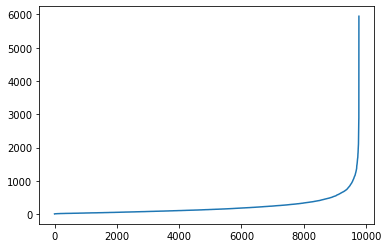

standard deviation =  261.2858582079654
median + 2*st.d=  654
max length selected, based on median + 2*st.d:  24


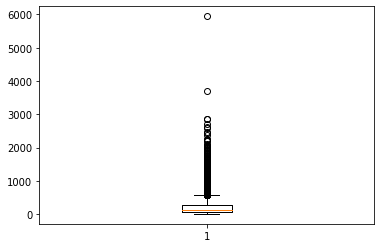

202.0 568.0 -240.0
IQR-based splitting point:  9060
max length selected, based on IQR:  567
labels balance:
 0    10070
1     7479
Name: 0, dtype: int64
avg of lengths =  117.2360248447205
max of lengths =  9783
min of lengths =  3
median=  57.0


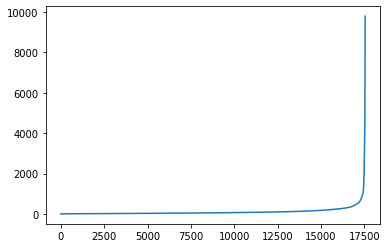

standard deviation =  331.7274825922585
median + 2*st.d=  720
max length selected, based on median + 2*st.d:  11


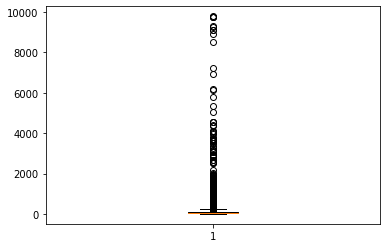

88.0 248.0 -104.0
IQR-based splitting point:  15957
max length selected, based on IQR:  247


In [5]:
comments = 1 # at zero -> delete
strings = 1
numericals = 1
headers = 1
rare = 1 # at zero remove rare
often = 1 # at zero remove too often

# from data_mining import data_miner
# data_miner('function.json')

df_ffmpeg = pd.read_csv(os.path.join('..','data', 'ffmpeg_data.csv'))
df_qemu = pd.read_csv(os.path.join('..','data', 'qemu_data.csv'))

#sequences = tokenSelector.dataTokenization(dataset, filename, comments, strings, numericals, headers)
df_ffmpeg["func"] = dataTokenization(df_ffmpeg['func'].tolist(), comments, strings, numericals, headers)
df_qemu["func"] = dataTokenization(df_qemu['func'].tolist(), comments, strings, numericals, headers)

# data analysis
ffmpeg_reduced = optLength(df_ffmpeg)
qemu_reduced = optLength(df_qemu)

# store projects' dataframes with reduced lenght in csv files
ffmpeg_reduced.to_csv(os.path.join('..','data', 'ffmpeg_data_reduced.csv'), index=False)
qemu_reduced.to_csv(os.path.join('..','data', 'qemu_data_reduced.csv'), index=False)

# read them
ffmpeg = pd.read_csv(os.path.join('..','data', 'ffmpeg_data_reduced.csv'))
qemu = pd.read_csv(os.path.join('..','data', 'qemu_data_reduced.csv'))